In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [2]:
df_raw = pd.read_csv('2017_WADI/WADI_attackdataLABLE.csv', header = 1)

In [3]:
import datetime
timestamp = pd.date_range("10/09/17 18:00:00", periods = 172801, freq = "s")
df = df_raw[:-2]
df['TimeStamp'] = timestamp
first_col = df.pop('TimeStamp')
df.insert(0, 'TimeStamp', first_col)
df = df.dropna(axis = 1)
df_clean = df.drop(['Row ', 'TimeStamp', 'Date ', 'Time', 'Attack LABLE (1:No Attack, -1:Attack)'], axis = 1)

def remove_1(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col, inplace=True, axis =1)
    return df

df_clean = remove_1(df_clean)

/var/folders/df/rwntvt1n6yj8034kn75rxjqw0000gn/T/ipykernel_84595/1580323211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TimeStamp'] = timestamp


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_clean))
df_scaled.columns = df_clean.columns

In [5]:
# Mask attacks associated with P1
mask1 = (df['TimeStamp'] > '2017-10-09 19:25:00') & (df['TimeStamp'] < '2017-10-09 19:50:16')
mask2 = (df['TimeStamp'] > '2017-10-10 10:24:10') & (df['TimeStamp'] < '2017-10-10 10:34:00')
mask3 = (df['TimeStamp'] > '2017-10-10 10:55:00') & (df['TimeStamp'] < '2017-10-11 11:24:00')
mask4 = (df['TimeStamp'] > '2017-10-11 10:55:00') & (df['TimeStamp'] < '2017-10-11 10:56:27')
mask5 = (df['TimeStamp'] > '2017-10-11 11:17:54') & (df['TimeStamp'] < '2017-10-11 11:31:20')
mask6 = (df['TimeStamp'] > '2017-10-11 12:16:00') & (df['TimeStamp'] < '2017-10-11 12:25:36')
mask7 = (df['TimeStamp'] > '2017-10-11 15:26:30') & (df['TimeStamp'] < '2017-10-11 15:37:00')

# Create new attack column which will be used to only have P1 attacks
df['P2_Attack'] = df['Attack LABLE (1:No Attack, -1:Attack)'] # Copy all attacks

# Ensure attacks associated with P1 are masked since we only want to have P2 attacks in P2_Attack
df.loc[mask1,'P2_Attack'] = 1
df.loc[mask2,'P2_Attack'] = 1
df.loc[mask3,'P2_Attack'] = 1
df.loc[mask4,'P2_Attack'] = 1
df.loc[mask5,'P2_Attack'] = 1
df.loc[mask6,'P2_Attack'] = 1
df.loc[mask7,'P2_Attack'] = 1


In [6]:
# Attacks on Distrubtion Network P2 mainly deal with Consumer Tank Inlet valves (MCV), booster pump pressure meter (PIT) and
# Flow rate (FIT) and booster pressure meter(PIT)

P2 = df_scaled[['2_MCV_101_CO', '2_MCV_201_CO', '2_MCV_301_CO', '2_MCV_401_CO', '2_MCV_501_CO', '2_MCV_601_CO',
               '2_PIT_002_PV', '2_PIT_003_PV', '2_FIT_003_PV', '2_FIT_002_PV']]


In [7]:
kmeans_P2 = KMeans(n_clusters =2, random_state = 22).fit_predict(P2)

P2Pred = pd.DataFrame()
P2Pred['Pred'] = kmeans_P2
P2Pred['P2_Attack'] = df['P2_Attack']

P2Pred['Pred'] = P2Pred['Pred'].replace(1,-1)
P2Pred['Pred'] = P2Pred['Pred'].replace(0,1)

confusion_matrix_P2 = pd.crosstab(P2Pred['P2_Attack'], P2Pred['Pred'], rownames = ['Actual'], colnames = ['Predicted'])
print(confusion_matrix_P2)

# accuracy 61% and TP rate 92%, extremely high false positive

Predicted     -1       1
Actual                  
-1           942     110
 1         68621  103128


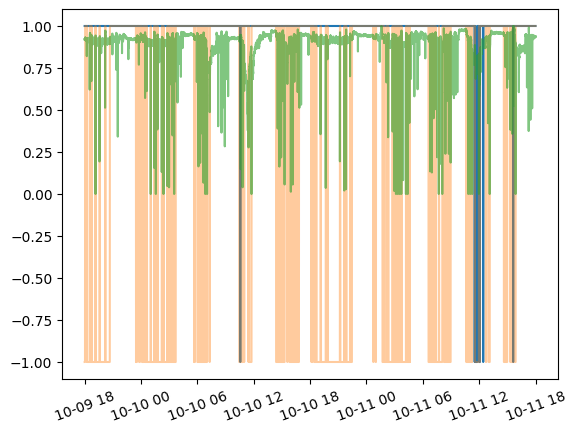

In [8]:
plt.plot(df['TimeStamp'], P2Pred['P2_Attack'])
plt.plot(df['TimeStamp'], P2Pred['Pred'],alpha = 0.4)
plt.plot(df['TimeStamp'], P2['2_PIT_002_PV'], alpha = 0.6)
plt.xticks(rotation = 20)
plt.show()

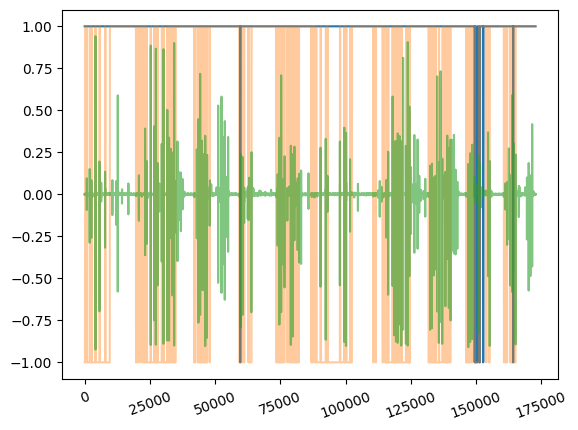

In [9]:
plt.plot(P2Pred['P2_Attack'])
plt.plot(P2Pred['Pred'],alpha = 0.4)
plt.plot(P2['2_PIT_002_PV'].diff(), alpha = 0.6)
plt.xticks(rotation = 20)
plt.show()

In [10]:
# play around with diff's
# '2_PIT_002_PV', '2_PIT_003_PV', '2_FIT_003_PV', '2_FIT_002_PV'
P2_diff = P2.copy()
P2_diff['2_PIT_002_PV'] = P2_diff['2_PIT_002_PV'].diff()
P2_diff['2_PIT_003_PV'] = P2_diff['2_PIT_003_PV'].diff()
P2_diff = P2_diff.iloc[1:,:]

kmeans_P2_PIT_diff = KMeans(n_clusters =2, random_state = 22).fit_predict(P2_diff)

P2Pred_PIT_diff = pd.DataFrame()
P2Pred_PIT_diff['Pred'] = kmeans_P2_PIT_diff
P2Pred_PIT_diff['P2_Attack'] = df['P2_Attack']

P2Pred_PIT_diff['Pred'] = P2Pred_PIT_diff['Pred'].replace(1,-1)
P2Pred_PIT_diff['Pred'] = P2Pred_PIT_diff['Pred'].replace(0,1)

confusion_matrix_P2_PIT_diff = pd.crosstab(P2Pred_PIT_diff['P2_Attack'], P2Pred_PIT_diff['Pred'], rownames = ['Actual'], colnames = ['Predicted'])
print(confusion_matrix_P2_PIT_diff)

# accuracy 61% and TP rate 92%, extremely high false positive'''

Predicted     -1       1
Actual                  
-1          1006      46
 1         68392  103356


In [11]:
P2_diff.head()

,2_MCV_101_CO,2_MCV_201_CO,2_MCV_301_CO,2_MCV_401_CO,2_MCV_501_CO,2_MCV_601_CO,2_PIT_002_PV,2_PIT_003_PV,2_FIT_003_PV,2_FIT_002_PV
1,0.0,0.0,0.200685,0.0,0.686983,0.356947,0.0,0.0,0.0,0.36862
2,0.0,0.0,0.200685,0.0,0.686983,0.356947,0.0,0.0,0.0,0.36862
3,0.0,0.0,0.200685,0.0,0.686983,0.356947,0.0,0.0,0.0,0.36862
4,0.0,0.0,0.200685,0.0,0.686983,0.356947,0.0,0.0,0.0,0.36862
5,0.0,0.0,0.200685,0.0,0.686983,0.356947,0.0,0.0,0.0,0.36862


In [12]:
df_scaled.columns

Index(['1_AIT_001_PV', '1_AIT_002_PV', '1_AIT_003_PV', '1_AIT_004_PV',
       '1_AIT_005_PV', '1_FIT_001_PV', '1_LT_001_PV', '1_MV_001_STATUS',
       '1_MV_002_STATUS', '1_MV_003_STATUS', '1_MV_004_STATUS',
       '1_P_001_STATUS', '1_P_003_STATUS', '1_P_005_STATUS', '1_P_006_STATUS',
       '2_DPIT_001_PV', '2_FIC_101_CO', '2_FIC_101_PV', '2_FIC_101_SP',
       '2_FIC_201_CO', '2_FIC_201_PV', '2_FIC_201_SP', '2_FIC_301_CO',
       '2_FIC_301_PV', '2_FIC_301_SP', '2_FIC_401_CO', '2_FIC_401_PV',
       '2_FIC_401_SP', '2_FIC_501_CO', '2_FIC_501_PV', '2_FIC_501_SP',
       '2_FIC_601_CO', '2_FIC_601_PV', '2_FIC_601_SP', '2_FIT_001_PV',
       '2_FIT_002_PV', '2_FIT_003_PV', '2_FQ_101_PV', '2_FQ_201_PV',
       '2_FQ_301_PV', '2_FQ_401_PV', '2_FQ_501_PV', '2_FQ_601_PV',
       '2_LS_101_AH', '2_LS_101_AL', '2_LS_201_AH', '2_LS_201_AL',
       '2_LS_301_AH', '2_LS_301_AL', '2_LS_401_AH', '2_LS_401_AL',
       '2_LS_501_AH', '2_LS_501_AL', '2_LS_601_AH', '2_LS_601_AL',
       '2_LT_001_PV'